# SunPy Tutorial DynaSun<img src="https://raw.githubusercontent.com/sunpy/sunpy.org/main/_static/img/sunpy_icon.svg" alt="logo" width="100" align="right"/>

In this tutorial we will go through an overview of some of the functionality available through the sunpy ecosystem.

In this notebook we'll go through an introduction of how we can use sunpy and other scientific packages such as astropy etc to perform solar data analysis. We'll focus on how to search and query data, download data, load data into different containers, overview the powerful functionality of the coordinate framework, and how to plot and manipulate data.


1. Data Search and Download
2. TimeSeries and Maps
3. Coordinates!
4. Fun things we can do - an oscillation example.

## If you are using google colab:
you will need to run the cell below (you'll need to uncomment it!)

In [32]:
# %pip install -r https://raw.githubusercontent.com/hayesla/DynaSun_workshop/main/requirements.txt

### Import the packages we'll use in this notebook

In [1]:
from sunpy.net import Fido, attrs as a
import sunpy.map
from sunpy.time import parse_time
import sunpy.timeseries
import sunpy.data.sample
from sunpy.coordinates import frames, get_horizons_coord, get_body_heliographic_stonyhurst
from sunpy.coordinates import SphericalScreen
import sunpy_soar

from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.visualization import AsymmetricPercentileInterval, ImageNormalize, LogStretch, AsinhStretch
from scipy.interpolate import interp1d

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import dates

# A note on units - using astropy Units

[`astropy.units`](https://docs.astropy.org/en/stable/units/) provides a means to deal with and handle numbers/arrays etc that have an associated physical quantity (e.g. km, seconds, Kelvin). Throughout SunPy, any physical input or outputs is an [`astropy.Quantity`](https://docs.astropy.org/en/stable/units/quantity.html#quantity). Lets look at how we can create and convert between astropy units. Above we have imported `astropy.units` as `u`

In [2]:
distance_in_km = 10*u.km

In [3]:
distance_in_km

<Quantity 10. km>

In [4]:
distance_in_km.value

np.float64(10.0)

In [5]:
distance_in_km.cgs

<Quantity 1000000. cm>

We can convert between units e.g.

In [6]:
distance_in_km.to(u.parsec)

<Quantity 3.24077929e-13 pc>

In [7]:
# distance_in_km.to(u.s)

In [8]:
time_in_sec = 60*u.s
distance_in_km/time_in_sec

<Quantity 0.16666667 km / s>

# A note about coordinates framework used - astropy SkyCoord and frames

In much the same way as units are used for representing physical quantities, sunpy uses astropy.coordinates to represent points in physical space. This applies to both points in 3D space and projected coordinates in images. `sunpy` extends the `astropy.coordinates` framework by adding additional solar-specific coordinate frames and the accompanying transformations between them.

The astropy coordinates module is primarily used through the [`SkyCoord`](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord)  class, which also makes use of the astropy units system:

A **coordinate** combines position data with a coordinate frame, and a SkyCoord object is created by passing in positions with specified units and a coordinate frame. Above in the imports cell we've imported [`sunpy.coordinates.frames`](https://docs.sunpy.org/en/stable/code_ref/coordinates/index.html#supported-coordinate-systems) which allow us to use solar physics specific frames such as Helioprojective, Heliographic Stonyhurst, Heliocentric etc. 

Lets create a point on the Sun in lat and long in the Heliographic Stonyhurst coordinate system

In [9]:
hgs_coord = SkyCoord(70*u.deg, -30*u.deg, obstime="2017-08-01",
                 frame=frames.HeliographicStonyhurst)

In [10]:
hgs_coord

<SkyCoord (HeliographicStonyhurst: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km): (lon, lat) in deg
    (70., -30.)>

In [11]:
hgs_coord.transform_to(frames.Helioprojective(observer="earth"))

<SkyCoord (Helioprojective: obstime=2017-08-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'earth'>): (Tx, Ty, distance) in (arcsec, arcsec, km)
    (769.96270814, -498.89715922, 1.51668773e+08)>

In [12]:
hgs_coord.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, km)
    (49.84856512, 0.05394699, 1417743.94689472)>

SkyCoord and all coordinate frames support array coordinates. These work the same as single-value coordinates, but they store multiple coordinates in a single object. When you’re going to apply the same operation to many different coordinates, this is a better choice than a list of SkyCoord objects, because it will be much faster than applying the operation to each SkyCoord in a for loop:

In [13]:
coord = SkyCoord([-500, 400]*u.arcsec, [100, 200]*u.arcsec, frame=frames.Helioprojective)
coord

<SkyCoord (Helioprojective: obstime=None, rsun=695700.0 km, observer=None): (Tx, Ty) in arcsec
    [(-500., 100.), ( 400., 200.)]>

## A quick note about observer location!

Both Helioprojective and Heliocentric frames are defined based on the position of the observer. Therefore to transform either of these frames to a different frame the location of the observer must be known. The observer can be specified for a coordinate object using the observer argument to SkyCoord. For sunpy to calculate the location of Earth or another solar-system body, it must know the time associated with the coordinate; this is specified with the obstime argument.

In [14]:
hpc = SkyCoord(0*u.arcsec, 0*u.arcsec, observer="earth",
                obstime="2022-03-01",
                frame=frames.Helioprojective)

In [15]:
hpc.transform_to(frames.Helioprojective(observer="venus"))

<SkyCoord (Helioprojective: obstime=2022-03-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate for 'venus'>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-686.00374528, -99.0917007, 0.71686044)>

In [16]:
solo_coord = get_horizons_coord("solo", "2022-03-01")

2024-09-04 23:27:38 - sunpy - INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144)


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144) [sunpy.coordinates.ephemeris]


In [17]:
hpc.transform_to(frames.Helioprojective(observer=solo_coord))

<SkyCoord (Helioprojective: obstime=2022-03-01T00:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-03-01T00:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-8.89113366, -4.01295729, 0.57642046)>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (257.21067742, -95.13463244, 0.57183307)>

# 1. Overview of Fido Unified Downloader
Fido is sunpy's interface for searching and downloading solar physics data.
It offers a unified interface for searching and fetching data irrespective of the underlying client or webservice from where the data is obtained.
You can also search and accesses multiple instruments and all available data providers in a single query.
It supplies a single, easy, consistent and extendable way to get most forms of solar physics data the community need.

For more information about Fido and how to use it check out the documentation on our website: https://docs.sunpy.org/en/stable/tutorial/acquiring_data/index.html

Fido offers access to data available through:

* VSO
* JSOC (through drms)
* Individual data providers from web accessible sources (http, ftp, etc)
* HEK
* HELIO
  
As described here Fido provides access to many sources of data through different clients, these clients can be defined inside sunpy or in other packages (e.g. DKIST data can be accessed using Fido through [DKIST User Tools](https://docs.dkist.nso.edu/projects/python-tools/en/latest/tutorial/2_search_and_asdf_download.html).

#### Importantly, Solar Orbiter data can be accessed through the client defined in the `sunpy_soar` affiliated package. 

Lets inspect what instrument and clients are available through Fido. 

In [18]:
Fido

<sunpy.net.fido_factory.UnifiedDownloaderFactory object at 0x114e42ff0>
sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`sunpy-tutorial-acquiring-data-index`.


      Client      ...
----------------- ...
CDAWEBClient      ...
ADAPTClient       ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...
SOARClient        ...

In [19]:
# a.Provider

## 1.1 Using attributes to search for data with Fido

Sunpy uses specified *attributes* to search for data using Fido. The range of these attributes is located in the `attrs` submodule. These `attr` parameters can be combined together to construct data search queries, such as searching over a certain time period, for data from a certain instrument with a certain wavelength etc.

Different clients and provides will have client-specific attributes, but the core attributes are:

* `a.Time`
* `a.Instrument`
* `a.Wavelength`


Lets look at how these attributes work in more detail.

First we can look at a.Time, which is used to specify the timerange of a query.

In [20]:
a.Time("2021-05-23 02:00", "2021-05-23 04:00")

<sunpy.net.attrs.Time(2021-05-23 02:00:00.000, 2021-05-23 04:00:00.000)>

In [21]:
a.Instrument.aia

<sunpy.net.attrs.Instrument(AIA: Atmospheric Imaging Assembly) object at 0x11b6f5f70>

To search for certain wavelengths, we need to specify the input as an `astropy Quantity` which is a the combination of a value and an associated unit. This is something is universal in the sunpy stack - that every physical input/output is a `Quantity`.

In [22]:
a.Wavelength(17.1*u.angstrom)

<sunpy.net.attrs.Wavelength(17.1, 17.1, 'Angstrom')>

## 1.2 Constructing a search query
 ### A simple query

Lets create a simple query to search for data from AIA over a particular time period

In [ ]:
result = Fido.search(a.Time("2022-03-28 11:00", "2022-03-28 12:00"), 
                     a.Instrument("AIA"))

Now lets make our query a bit more specific, say, say we only want one wavelength band from AIA. This can be achieved by specifying the `Wavelength` attribute within the search. The `a.Wavelength` attribute is passed as an `astropy.Quantity`:

In [ ]:
result = Fido.search(a.Time("2022-04-02 12:00", "2022-04-02 13:00"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(304*u.angstrom))

We can also further specify this query to only search for 10 minute sampling data

In [ ]:
result = Fido.search(a.Time("2022-04-02 12:00", "2022-04-02 13:00"), 
                     a.Instrument("AIA"), 
                     a.Wavelength(304*u.angstrom), 
                     a.Sample(10*u.min))

In [ ]:
result

In [ ]:
result[0][0]

## 1.3 Downloading the data

Now we can show how data that is queried above can be downloaded. Once the data you have searched for (and filtered etc) is constructed into a query using `Fido.search`, you can then easily download them using `Fido.fetch`.

The data is downloaded via asynchronous and parallel download streams (via parfive), and also allows for failed data downloads to be recognized so that files can be re-requested if not downloaded.

Lets now look at how a `UnifiedResponse` from a `Fido.search` can be passed to `Fido.fetch` to download the data

In [ ]:
f = Fido.fetch(result[0][0])

### Making combined queries - for example, we can search for AIA, Solar Orbiter, and GOES-XRS data

In addition to making a query to one client for one instrument, Fido allows the flexibility to search for data from multiple instruments, wavelengths, times etc, even when the data is being obtained through different clients.

This query can be constructed by using the pipe `|` operator, which joins queries together just like the OR operator.

In [ ]:
combined_res = Fido.search(a.Time("2022-04-02 12:00", "2022-04-02 14:30"),
                       (a.Instrument.aia & a.Wavelength(171*u.angstrom) & a.Sample(10*u.min)) | 
                       (a.Instrument.eui & a.Level(2) & a.soar.Product("EUI-FSI174-IMAGE")) | 
                       (a.Instrument.xrs & a.goes.SatelliteNumber(16) & a.Resolution.flx1s))

In [ ]:
combined_res

In [ ]:
# Fido.fetch(combined_res, path="./{instrument}/{file}")

2 . Data Containers
=============

Now we have seen how we can search for and download data - lets now look at how we can read this data in.

SunPy provides core data type classes that are designed to provide a consistent interface across data types (timeseries and images) as well as data sources from numerous instruments and observations. They handle all of the manipulation necessary to read data in from mission-specific files. The two main datatypes in SunPy are the `TimeSeries` and `Map` classes.

## 2.1 TimeSeries

The structure of a [`TimeSeries`](https://docs.sunpy.org/en/stable/guide/data_types/timeseries.html) consists of times and measurements and the underlying structure is that of a `pandas.DataFrame`. 

SunPy TimeSeries supports time-series data from a wide range of solar-focused instruments. `TimeSeries` can either be created manually or from source files that are currently supported. If a supported file is passed to `TimeSeries` it will automatically detect its source and its instrument-specific meta data will be loaded. 

Lets create a timeseries from out sample data which is X-ray flux from the GOES X-ray Sensor Data. This data file was downloaded locally in the steps above! 

In [ ]:
xrs_file = sunpy.data.sample.GOES_XRS_TIMESERIES

In [ ]:
xrs_file

In [ ]:
xrs = sunpy.timeseries.TimeSeries(xrs_file)

In [ ]:
xrs.plot()

In [ ]:
xrs.units

In [ ]:
xrs.meta

In [ ]:
xrs.to_dataframe()

## Manipulating the timeseries data

We can manipulate the timeseries, such as truncating (slicing) the data over a certain time period

In [ ]:
goes_flare = xrs.truncate("2011-06-07 05:00", "2011-06-07 09:00")
goes_flare.plot()

In [ ]:
xrs_df = xrs.to_dataframe()

In [ ]:
xrs_df.plot()
plt.yscale("log")

In [ ]:
xrs_df_resample = xrs_df.resample("60s").mean()
xrs_df_resample[["xrsa", "xrsb"]].plot()
plt.yscale("log")

# 2.2 Map
The sunpy [`Map`](https://docs.sunpy.org/en/stable/guide/data_types/maps.html) class provides the data type structure to store 2-dimensional data associated with a coordinate system.  This allows users to store and manipulate images of the Sun and the heliosphere.

The result of a call to Map will be either a `GenericMap` object, or a subclass of `GenericMap` which either deals with a specific type of data, e.g. `AIAMap` or `LASCOMap` (see sunpy.map Package to see a list of all of them), or if no instrument matches, a 2D map GenericMap.

Maps from all instruments are created using the `sunpy.map.Map` 'factory'. This class takes a wide variety of map-like inputs, for one or more maps and returns you one or many maps. All maps, irrespective of the instrument, behave the same and expose the same functions and properties, however, depending on the instrument different metadata might be read or corrections made.

In [ ]:
aia_file = sunpy.data.sample.AIA_171_IMAGE
aia_file

In [ ]:
aia_map = sunpy.map.Map(aia_file)

In [ ]:
type(aia_map)

In [ ]:
aia_map

`Map` provides customized loaders for a number of different instruments, however, if the data file follows the FITS data standards for coordinate information etc then map should be able to read it by default.

In [ ]:
fig = plt.figure()
aia_map.plot(clip_interval=[5, 99.8]*u.percent)

In [ ]:
fig = plt.figure()
aia_map.plot(clip_interval=[5, 99.8]*u.percent, cmap="viridis")

In [ ]:
fig = plt.figure()
aia_map.plot(clip_interval=[5, 99.8]*u.percent)
aia_map.draw_limb(color='b')
aia_map.draw_grid()

## Attributes of Map

Map has a set of attributes which give access to common metadata, which provides a consistent interface for different instruments, lets look at some of these here
The `.meta` and `.data` attributes provide access to the metadata and underlying array of image data, respectively.


In [ ]:
aia_map.data

In [ ]:
aia_map.wavelength

In [ ]:
aia_map.processing_level

In [ ]:
aia_map.max()

### Coordinate Information

Each `Map` also exposes information about which coordinate system the image was taken in, including the location of the spacecraft that recorded that observation.

`sunpy` leverages and extends the powerful astropy coordinate framework that we heard about in the previous tutorial. Additionally, we'll talk more about the sunpy.coordinates subpackage in the next notebook and show some neat examples.

For each `Map`, we can easily access what coordinate frame the observation cooresponds to.

This tells us that the coordinate system of the image is Helioprojective (HPC) and that it is defined by an observer at a particular location. This observer coordinate is also provided as an attribute,

In [ ]:
aia_map.coordinate_frame

In [ ]:
aia_map.observer_coordinate

In [ ]:
aia_map.bottom_left_coord

## World and Pixel coordinates

But what if we wanted to know what pixel these physical coordinates correspond to? Each Map has an associated World Coordinate System, or WCS, which is derived from the underlying metadata and expressed as an astropy.wcs.WCS object. The WCS is accessible as an attribute`aia_map.wcs`

WCS provides the transformation between the pixel coordinates of the image and physical or “world” coordinates. We can convert between the world coordinates (arcsec) to pixel coordinates using the `world_to_pixel` method on map which takes a `SkyCoord` and then returns the pixel coordinate. Similarly we can find the world coordinate to the pixel (or array) index. This is done with the `pixel_to_world` method. Lets first look at finding the array (pixel) index for the center of the Sun (0, 0) arcsec:

In [ ]:
aia_map.world_to_pixel(SkyCoord(0*u.arcsec, 0*u.arcsec, frame=aia_map.coordinate_frame))

In [ ]:
aia_map.pixel_to_world(0*u.pix, 0*u.pix)

# Crop a map

We commonly want to pare down our full field-of-view to a particular region of interest.
With a map, we can do this using the `submap` method.

To crop a map, we can pass either a SkyCoord (i.e. a coordinate in space), or in pixel space (i.e. by passing pixel coordinates).

We can specify the region of our submap using world coordinates as specified by a `SkyCoord`.
These coordinates can be specified in different coordinate systems and still should work (e.g. helioprojective or heliograhic stonyhurst)


In [ ]:
bottom_left = SkyCoord(-300*u.arcsec, 20*u.arcsec, frame=aia_map.coordinate_frame)
top_right = SkyCoord(390*u.arcsec, 650*u.arcsec, frame=aia_map.coordinate_frame)

In [ ]:
submap = aia_map.submap(bottom_left, top_right=top_right)

In [ ]:
fig = plt.figure()
submap.plot(clip_interval=[1, 99.9]*u.percent)

In [ ]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=(0.1, 99.99)*u.percent)

aia_map.draw_quadrangle(bottom_left, 
                        top_right=top_right, 
                        axes=ax1)

ax2 = fig.add_subplot(1,2,2,projection=submap)
submap.plot(clip_interval=(0.5, 99.95)*u.percent)

## Resampling a Map

In [ ]:
aia_map.resample([40, 40] * u.pixel).plot()

## A note on plotting with WCSAxes

SunPy map uses the [`astropy.visualization.wcsaxes`](https://docs.astropy.org/en/stable/visualization/wcsaxes/index.html#module-astropy.visualization.wcsaxes) module to represent world coordinates. 

Using WCSAxes is very powerful but has important concepts to think about:

 * **`world`** coordinates refer to the coordinates of the coordinate system - i.e. arcsec, degrees!
 * **`pixel`** coordinates refer to the array index of the data! i.e. data[10, 10] etc
 
 
When plotting on WCSAxes it will by default plot in pixel coordinates, you can override this behavior and plot in `world` coordinates by getting the transformation from the axes with `ax.get_transform('world')`. We will use some of these examples below. Its also important to note that when using the `world` coordinates these have to be in **degrees** so make sure to convert arcsec's to degrees.

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(projection=aia_map)  

# plot the map
aia_map.plot(clip_interval=[0.5, 99.99]*u.percent)
aia_map.draw_limb()
aia_map.draw_grid()

# plot in pixel coordinates
ax.plot(200, 200, marker='o', color="b",  label="Pixel coord")

# plot in world coordinates
ax.plot((200*u.arcsec).to(u.deg), (200*u.arcsec).to(u.deg),
        transform=ax.get_transform('world'), 
        marker='o',color="g", label="World Coord")
ax.legend()



You can also plot SkyCoords on a Map. Importantly, this can be done with ax.plot_coord and the coordinate does not need to be transformed to the same coordinate frame as the map - it is done automatically if it can be


In [ ]:
coord1 = SkyCoord(200*u.arcsec, -500*u.arcsec, frame=aia_map.coordinate_frame)
coord2 = SkyCoord(20*u.deg, 30*u.deg, frame=frames.HeliographicStonyhurst)

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=[0.5, 99.99]*u.percent)

aia_map.draw_grid(axes=ax)

ax.plot_coord(coord1, marker='o', ms=10, color='b')
ax.plot_coord(coord2, marker='x', ms=10, color='b')

# Sequence of Maps

A MapSequence is an ordered list of maps. By default, the maps are ordered by their observation date, from earliest to latest date. Lets use a time list of maps that we have already downloaded and generate them into a movie. 

In [23]:
aia_files = [sunpy.data.sample.AIA_193_CUTOUT01_IMAGE,
             sunpy.data.sample.AIA_193_CUTOUT02_IMAGE,
             sunpy.data.sample.AIA_193_CUTOUT03_IMAGE,
             sunpy.data.sample.AIA_193_CUTOUT04_IMAGE,
             sunpy.data.sample.AIA_193_CUTOUT05_IMAGE,]

In [24]:
aia_map_sequence = sunpy.map.Map(aia_files, sequence=True)

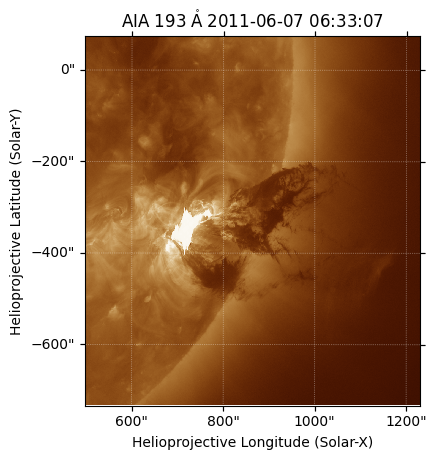

In [25]:
aia_map_sequence[0].plot()

2024-09-04 23:27:51 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-09-04 23:27:51 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y aia-maps-seq.mp4


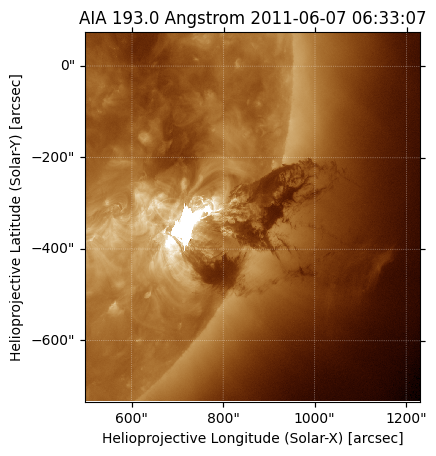

In [26]:
ani = aia_map_sequence.plot(cmap=aia_map_sequence[0].plot_settings['cmap'],
                            norm=ImageNormalize(vmin=1, vmax=1e4,
                                        stretch=aia_map_sequence[0].plot_settings['norm'].stretch))
ani.save('aia-maps-seq.mp4', fps=15, dpi=300)

In [28]:
from IPython.display import Video

Video('aia-maps-seq.mp4', embed=True, width=600)

## Running Difference

In [ ]:
aia_diff_map = (aia_map_sequence[1] - aia_map_sequence[0].quantity)

In [ ]:
aia_diff_map.plot(norm=colors.Normalize(), vmin=-500, vmax=500, cmap="binary")
aia_diff_map.draw_limb()
plt.colorbar()

In [ ]:
aia_diff_deq = sunpy.map.Map(
    [m - prev_m.quantity for m, prev_m in zip(aia_map_sequence[1:], aia_map_sequence[:-1])],
    sequence=True
)

In [ ]:
ani = aia_diff_deq.plot( title='Running Difference', 
                         norm=colors.Normalize(vmin=-500, vmax=500), cmap='Greys_r')
ani.save('diff_aia-maps-seq.mp4', fps=15, dpi=300)

In [29]:
Video('diff_aia-maps-seq.mp4', embed=True, width=600)

# 3. Coordinates

SunPy uses [`astropy.coordinates`](https://docs.astropy.org/en/stable/coordinates/index.html) to represent points in physical space. This applies to both points in 3D space and projected coordinates in images.

The SunPy coordinate framework extends the Astropy coordinates framework, and the coordinates subpackage of sunpy provides: 

* A robust framework for working with solar-physics coordinate systems

* Functions to obtain the locations of solar-system bodies (sunpy.coordinates.ephemeris)

* Functions to calculate Sun-specific coordinate information (sunpy.coordinates.sun)

* Bridge module to enable the use of the SkyCoord API to perform computations using SPICE kernels (sunpy.coordinates.spice)


We've already had some introduction to the coordinate framework above!

## Positions of solar system bodies
`sunpy.coordinates` provides functions to obtain the coordinates of solar-system bodies.
The function `get_body_heliographic_stonyhurst` which will return the location of the solar-system body in the `HeliographicStonyhurst` frame.

For other solar-system bodies (e.g., major man-made spacecraft or comets), you can use `get_horizons_coord()`, which queries JPL HORIZONS:

In [ ]:
earth_pos = get_body_heliographic_stonyhurst("earth", "2022-04-02")

In [ ]:
solo_pos = get_horizons_coord("solar orbiter", "2022-04-02")

In [ ]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(projection='polar')

ax.plot(solo_pos.lon.to('rad'), solo_pos.radius,
        '.', markersize=10, label='Solar Orbiter', color='r')
ax.plot(earth_pos.lon.to('rad'), earth_pos.radius,
        '.', markersize=10, label='Earth', color='b')
ax.plot(0, 0, markersize=10, marker='o', color='yellow')

ax.legend(loc='lower right')
ax.set_theta_zero_location("S")
ax.set_title('Positions in Heliographic Stonyhurst (HGS)')

In [ ]:
image_res = Fido.search(a.Time("2022-04-02 13:00", "2022-04-02 13:10"),
                       (a.Instrument.aia & a.Wavelength(171*u.angstrom) & a.Sample(10*u.min)) | 
                       (a.Instrument.eui & a.Level(2) & a.soar.Product("EUI-FSI174-IMAGE")))

In [ ]:
Fido.fetch(image_res, path="./{instrument}/{file}")

In [ ]:
aia_map = sunpy.map.Map("AIA/aia.lev1.171A_2022_04_02T13_00_09.35Z.image_lev1.fits")

In [ ]:
eui_map = sunpy.map.Map("EUI/solo_L2_eui-fsi174-image_20220402T130045231_V01.fits")

In [ ]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1,2,1,projection=aia_map)
ax2 = fig.add_subplot(1,2,2,projection=eui_map)

aia_map.plot(axes=ax1, clip_interval=[5, 99.9]*u.percent)
aia_map.draw_grid()
eui_map.plot(axes=ax2)
eui_map.draw_grid()

### Plot the solar limb as seen from EUI on AIA map
We can plot the solar limb as seen from EUI on the AIA map

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax1, clip_interval=[5, 99.9]*u.percent)
aia_map.draw_limb(axes=ax1, color='white')
eui_map.draw_limb(axes=ax1, color='blue', label="EUI limb")
plt.legend()

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_subplot(projection=eui_map)
eui_map.plot(axes=ax1)
eui_map.draw_limb(axes=ax1, color='white')
aia_map.draw_limb(axes=ax1, color='green', label="AIA limb")
plt.legend()



## The solar flare and eruption is both seen by SDO/AIA and from SolO/EUI, just from two different points of view.

Lets define the point and plot the point of the flare as seen by AIA

In [ ]:
flare_coord_aia = SkyCoord(830*u.arcsec, 263*u.arcsec, frame=aia_map.coordinate_frame)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot()
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=eui_map)
eui_map.plot()
ax.plot_coord(flare_coord_aia, marker='X', color='b', ms=10)

## Reproject AIA to field of view of Solo

Lets say for this observation, we want to identify what the AIA field of view looks like from the observer of Solar Orbiter. We can do this by using `reproject`.

For the sake of computation, lets reduce the size of the AIA map to [512, 512] pixels.

In [ ]:
aia_map = aia_map.resample((512, 512)*u.pix)

The role of "rsun" is important in sunpy, and different teams define "rsun" slighly differently in their fits metadata as rsun_ref, however they need to be the same to do reprojections-  see https://docs.sunpy.org/en/stable/topic_guide/rsun.html for more details on this. 

In [ ]:
eui_map.meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)
aia_map.meta["rsun_ref"] = sunpy.sun.constants.radius.to_value(u.m)

In [ ]:
eui_map_reproject_aia = eui_map.reproject_to(aia_map.wcs)
eui_map_reproject_aia.plot()
eui_map_reproject_aia.draw_limb(color='g')

In [ ]:
aia_map_reproject_eui = aia_map.reproject_to(eui_map.wcs)

aia_map_reproject_eui.plot()
aia_map_reproject_eui.draw_limb(color='k')

# Kink oscillation loop example

Let use the tools we've just learnt about to do study some loop oscillations in the solar corona as observed by SDO AIA. Here, we can look at the kink mode oscillations. 
The active region of interest here is taken from Goddard et al. 2016 - see https://www.aanda.org/articles/aa/abs/2016/01/aa27341-15/aa27341-15.html.

This is from an active region in 2012-10-20 and kink mode oscillations assocaited with an M-class flare.

We can use the observations from AIA to take a slice through the certain cuts and make time-distance plots

In [30]:
res = Fido.search(a.Time("2012-10-20T18:08:00", "2012-10-20 18:30"), 
                  a.Instrument.aia, 
                  a.Wavelength(171*u.angstrom))

f = Fido.fetch(res, path="./{instrument}/{file}")

Files Downloaded:   0%|          | 0/110 [00:00<?, ?file/s]

In [33]:
aia_maps = []
for filename in f:
    m_aia_full = sunpy.map.Map(filename)
    m_aia_full = m_aia_full/m_aia_full.exposure_time
    bottom_left = SkyCoord(-1150*u.arcsec, -500*u.arcsec,  observer=m_aia_full.observer_coordinate, frame="helioprojective")
    top_right = SkyCoord(-850*u.arcsec, -30*u.arcsec,  observer=m_aia_full.observer_coordinate, frame="helioprojective")
    m_aia_cutout = m_aia_full.submap(bottom_left, top_right=top_right)
    aia_maps.append(m_aia_cutout)
aia_maps = sunpy.map.Map(aia_maps, sequence=True)

2024-09-04 23:32:07 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-09-04 23:32:07 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 15 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y aia-maps-seq2.mp4


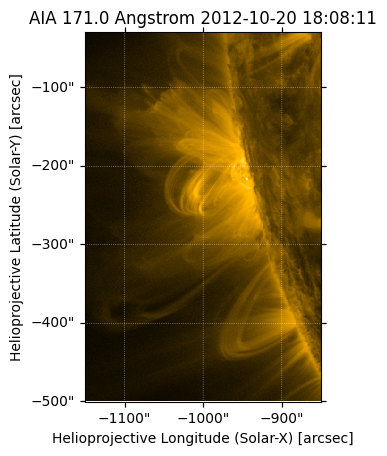

In [34]:
ani = aia_maps.plot(cmap=aia_maps[0].plot_settings['cmap'],
                            norm=ImageNormalize(vmin=1, vmax=1e4,
                                        stretch=aia_maps[0].plot_settings['norm'].stretch))
ani.save('aia-maps-seq2.mp4', fps=15, dpi=300)

In [36]:
Video('aia-maps-seq2.mp4', embed=True, width=600)

Lets define a line over some oscillating loops!

In [37]:
traced_loop = SkyCoord(
    Tx=[-1060, -1030]*u.arcsec,
    Ty=[-220, -230]*u.arcsec,
    frame=aia_maps[0].coordinate_frame,
)

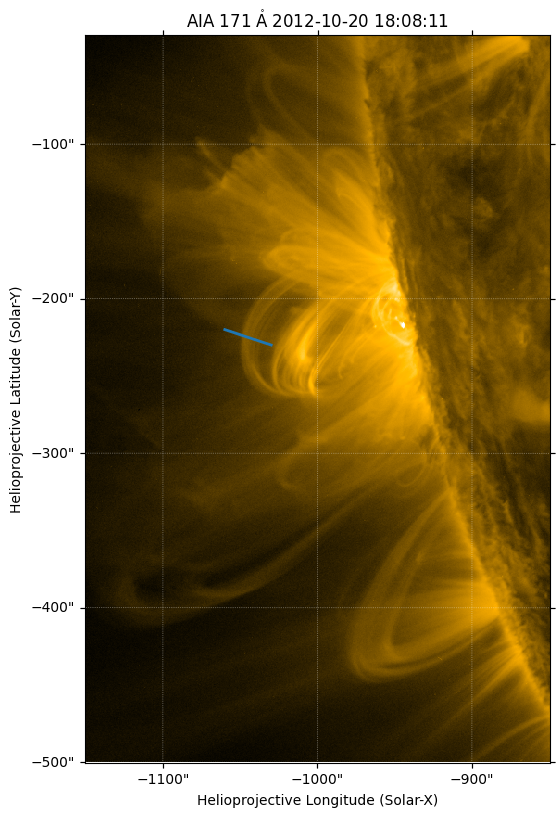

In [38]:
fig = plt.figure(figsize=(6, 10))
ax = fig.add_subplot(projection=aia_maps[0])
aia_maps[0].plot()
ax.plot_coord(traced_loop, lw=2)

Next, we convert the world coordinates of the traced loop to pixel coordinates on the map. This is important because the map data is stored in pixel units, and by pixelating the path, we can ensure that the traced loop aligns with the pixel grid of the map.

We use the `sunpy.map.pixelate_coord_path()` function, which takes the traced_loop coordinates and maps them onto the pixel grid of the `aia_maps[0]` solar image.

In [39]:
traced_loop_pixelated = sunpy.map.pixelate_coord_path(aia_maps[0], traced_loop)


In [40]:
traced_loop_pixelated

<SkyCoord (Helioprojective: obstime=2012-10-20T18:08:12.340, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2012-10-20T18:08:12.340, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.00503251, 5.40196597, 1.48890361e+11)>): (Tx, Ty) in arcsec
    [(-1060.18489746, -219.92323663), (-1059.58542432, -219.92303785),
     (-1059.58522225, -220.52251822), (-1058.9857491 , -220.52231944),
     (-1058.38627592, -220.52212066), (-1057.78680273, -220.52192188),
     (-1057.78660066, -221.12140228), (-1057.18712746, -221.1212035 ),
     (-1056.58765423, -221.12100473), (-1055.98818098, -221.12080595),
     (-1055.98797892, -221.72028637), (-1055.38850565, -221.72008759),
     (-1054.78903237, -221.71988882), (-1054.18955908, -221.71969004),
     (-1054.18935701, -222.31917049), (-1053.58988369, -222.31897172),
     (-1052.99041036, -222.31877295), (-1052.39093701, -222.31857418),
     (-1052.39073494, -222.91805464), (-1051.79126157, -222.91785588),
     (-1051

We now want to calculate the distance along the traced loop.
We compute the separation distance between each point along the traced loop. This calculates the distance between the first point in the loop (traced_loop_pixelated[0]) and every other point along the pixelated loop path, giving us a measure of how far the loop extends in terms of physical distance on the map.

In [41]:
traced_loop_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])

This gives us a quantified measurement of the loop’s length, which can later be used for further analysis of the solar structure, such as estimating the magnetic field properties or plasma flows along the loop.

In [42]:
traced_loop_distance

<Angle [0.        , 0.00016652, 0.0002355 , 0.00037235, 0.00052658,
        0.00068658, 0.0007447 , 0.00089674, 0.00105317, 0.00121229,
        0.00126819, 0.00142275, 0.00157975, 0.00173853, 0.00179348,
        0.00194908, 0.00210634, 0.00226493, 0.00231937, 0.00247551,
        0.00263292, 0.0027914 , 0.00284551, 0.003002  , 0.00315951,
        0.0033179 , 0.00337179, 0.00352851, 0.00368609, 0.00384443,
        0.00389815, 0.00405505, 0.00421268, 0.00437097, 0.00442457,
        0.00458159, 0.00473926, 0.00489752, 0.00495102, 0.00510815,
        0.00526585, 0.00542408, 0.0054775 , 0.00563471, 0.00579243,
        0.00595064, 0.00600399, 0.00616127, 0.00631902, 0.00647721,
        0.0065305 , 0.00668784, 0.00684561, 0.00700378, 0.00705703,
        0.00721441, 0.00737219, 0.00753035, 0.00758356, 0.00774098,
        0.00789878, 0.00805692, 0.0081101 , 0.00826755, 0.00842536,
        0.0085835 , 0.00863664, 0.00879413] deg>

Next, we are extracting and interpolating intensity values along a traced loop from the series of `aia_maps`. We begin by looping through each map and converting the loop coordinates to pixel coordinates, ensuring alignment with the pixel grid of the map. For each map, we adjust the projection system to account for the observer's perspective and calculate the distance between each point along the pixelated loop. We then sample the intensity values along the loop and use linear interpolation to map these values to a consistent set of distance coordinates across all maps. The interpolated intensity values for each map are stored in intensity_stack, which is ultimately converted into a Quantity object for further analysis. This approach allows us to track how intensity evolves along the loop over the sequence of solar images.

In [43]:
intensity_stack = []
for m in aia_maps:
    with SphericalScreen(m.observer_coordinate):
        _traced_loop_pixelated = sunpy.map.pixelate_coord_path(m, traced_loop)
    _traced_loop_distance = _traced_loop_pixelated.separation(_traced_loop_pixelated[0])
    intensity = sunpy.map.sample_at_coords(m, _traced_loop_pixelated)
    f_interp = interp1d(_traced_loop_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
    intensity_interp = f_interp(traced_loop_distance.to_value('arcsec'))
    intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
intensity_stack = u.Quantity(intensity_stack)

lets get the time array and the distance along slit in arcsec

In [44]:
time_array = [m.date.datetime for m in aia_maps]
distance = traced_loop_distance.to(u.arcsec)

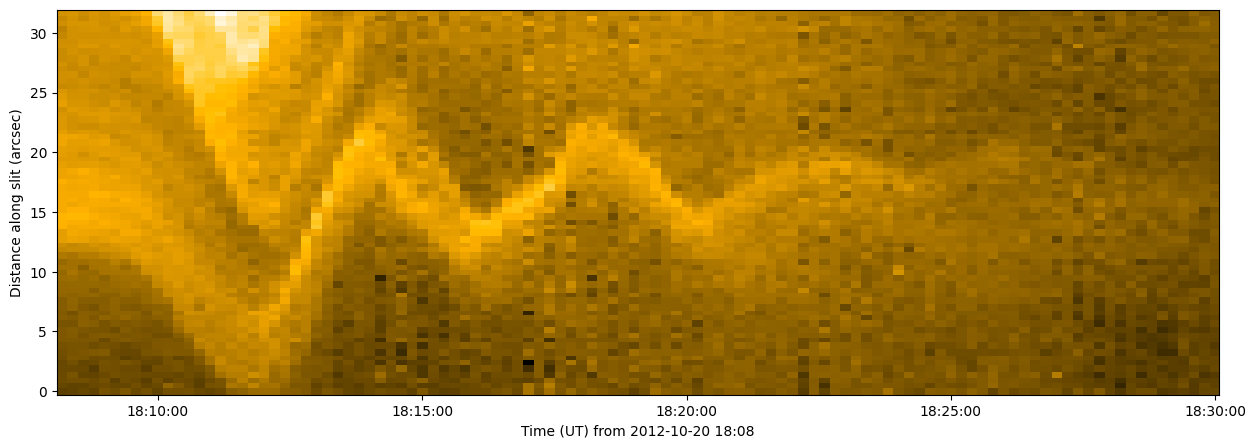

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.pcolormesh(time_array, distance.value, intensity_stack.value.T, 
               norm=ImageNormalize(stretch=AsinhStretch()), cmap="sdoaia171")

ax.set_ylabel("Distance along slit (arcsec)")
ax.set_xlabel("Time (UT) from {:s}".format(time_array[0].strftime("%Y-%m-%d %H:%M")))
ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M:%S"))

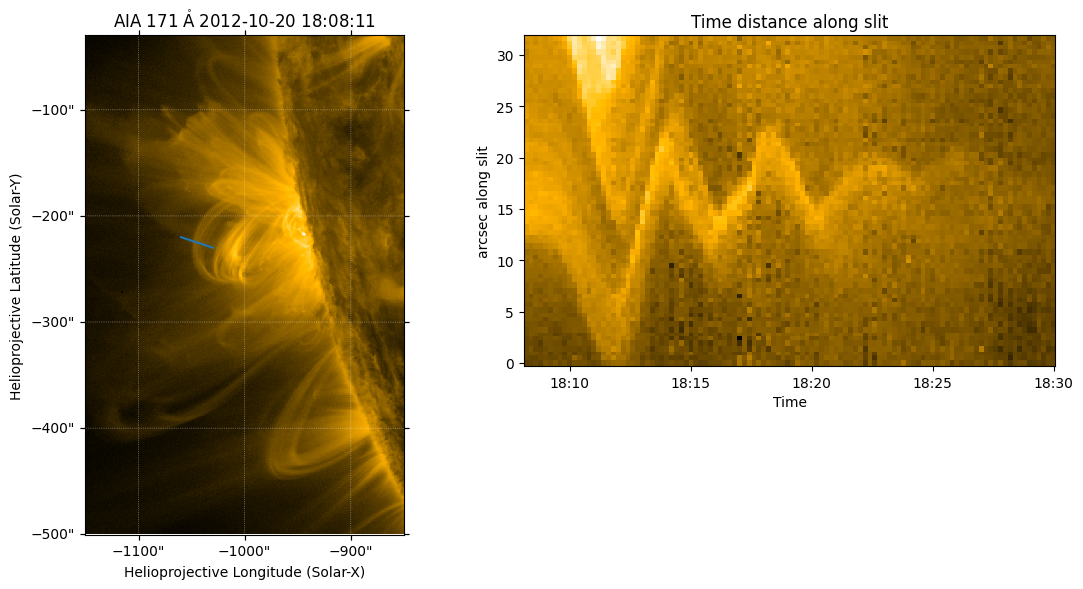

In [46]:
fig = plt.figure(figsize=(12, 6))

gs = fig.add_gridspec(2, 2, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[:, 0], projection=aia_maps[0])

ax2 = fig.add_subplot(gs[0, 1])

aia_maps[0].plot(axes=ax1)
ax1.plot_coord(traced_loop)


ax2.pcolormesh(time_array, distance.value, intensity_stack.value.T, 
               norm=ImageNormalize(stretch=AsinhStretch()), cmap="sdoaia171")
ax2.set_ylabel("arcsec along slit")
ax2.set_xlabel("Time")
ax2.set_title("Time distance along slit")
ax2.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
plt.tight_layout()
